# Imports

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import Binarizer

# Use Dataset

In [6]:
df = pd.read_csv('dataset/mobile_addiction_data.csv')

df.head()

,User_ID,Country,Age,Gender,Occupation,Education_Level,Income_USD,Daily_Screen_Time_Hours,Phone_Unlocks_Per_Day,Social_Media_Usage_Hours,...,Online_Shopping_Hours,Internet_Connection_Type,Primary_Device_Brand,Has_Screen_Time_Management_App,Self_Reported_Addiction_Level,Monthly_Data_Usage_GB,Has_Night_Mode_On,Age_First_Phone,Push_Notifications_Per_Day,Tech_Savviness_Score
0,1,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,...,1.85,5G,Other,No,Low,16.43,Yes,16,106,39.36
1,2,UK,26,Male,Artist,Master's,41868.19,9.05,61,3.13,...,0.66,4G,Samsung,Yes,Severe,32.87,No,12,111,9.45
2,3,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,...,-0.14,WiFi,Samsung,Yes,Severe,27.45,No,18,90,50.27
3,4,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,...,0.17,3G,Apple,Yes,Moderate,30.85,No,17,60,30.82
4,5,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,...,0.58,3G,Xiaomi,No,High,10.38,Yes,18,127,21.70


In [7]:

# Forma e datasetit
print("Number of rows::",df.shape[0])
print("Number of columns::",df.shape[1])
print("==================================================================")

# Llojet e atributeve
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Atributet kategorike", categorical_columns)
print("Atributet numerike", numerical_columns)

Number of rows:: 3000
Number of columns:: 34
Atributet kategorike Index(['Country', 'Gender', 'Occupation', 'Education_Level',
       'Relationship_Status', 'Has_Children', 'Urban_or_Rural',
       'Internet_Connection_Type', 'Primary_Device_Brand',
       'Has_Screen_Time_Management_App', 'Self_Reported_Addiction_Level',
       'Has_Night_Mode_On'],
      dtype='object')
Atributet numerike Index(['User_ID', 'Age', 'Income_USD', 'Daily_Screen_Time_Hours',
       'Phone_Unlocks_Per_Day', 'Social_Media_Usage_Hours',
       'Gaming_Usage_Hours', 'Streaming_Usage_Hours', 'Messaging_Usage_Hours',
       'Work_Related_Usage_Hours', 'Sleep_Hours', 'Physical_Activity_Hours',
       'Mental_Health_Score', 'Depression_Score', 'Anxiety_Score',
       'Stress_Level', 'Time_Spent_With_Family_Hours', 'Online_Shopping_Hours',
       'Monthly_Data_Usage_GB', 'Age_First_Phone',
       'Push_Notifications_Per_Day', 'Tech_Savviness_Score'],
      dtype='object')


In [10]:
#columns name formatting

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [8]:
print("General Statistics::\n")
print(df.info())

print("Summary Statistics::\n")
print(df.describe(include='all'))

General Statistics::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         3000 non-null   int64  
 1   country                         3000 non-null   object 
 2   age                             3000 non-null   int64  
 3   gender                          3000 non-null   object 
 4   occupation                      3000 non-null   object 
 5   education_level                 2388 non-null   object 
 6   income_usd                      3000 non-null   float64
 7   daily_screen_time_hours         3000 non-null   float64
 8   phone_unlocks_per_day           3000 non-null   int64  
 9   social_media_usage_hours        3000 non-null   float64
 10  gaming_usage_hours              3000 non-null   float64
 11  streaming_usage_hours           3000 non-null   float64
 12  messaging_us

In [49]:
# drop unnecessary columns
df = df.drop(columns=[
    'user_id',
    'primary_device_brand',
    'internet_connection_type',
    
], errors='ignore')

df.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,gender_Male,gender_Other,relationship_status_Divorced,relationship_status_In Relationship,relationship_status_Married,relationship_status_Single,urban_or_rural_Rural,urban_or_rural_Urban,has_children_False,has_children_True
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,0.00,...,True,False,False,False,False,True,True,False,True,False
1,UK,26,Male,Artist,Master,41868.19,9.05,61,3.13,2.50,...,True,False,False,True,False,False,True,False,True,False
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,False,True,False,False,False,True,False,True,False,True
3,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,2.70,...,False,False,False,True,False,False,False,True,True,False
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,False,True,True,False,False,False,False,True,True,False


In [10]:

# Vlerat e zbrazëta
print("Columns with Missing Values::", df.columns[df.isnull().any()].tolist())
print("Number of rows with Missing Values::", df.isnull().any(axis=1).sum())
print("Sample Indices with missing data::", df.isnull().any(axis=1).to_numpy().nonzero()[0].tolist()[0:10])

Columns with Missing Values:: ['education_level']
Number of rows with Missing Values:: 612
Sample Indices with missing data:: [3, 4, 8, 16, 18, 40, 44, 45, 55, 66]


In [11]:
numeric_df = df.select_dtypes(include=[np.number])

negatives_mask = numeric_df < 0

negatives_count = negatives_mask.sum()

print("=== Negative Number Summary ===")
for col, count in negatives_count.items():
    if count > 0:
        print(f"{col}: {count} negative values")
    else:
        print(f"{col}: No negative values")

=== Negative Number Summary ===
age: No negative values
income_usd: 81 negative values
daily_screen_time_hours: 9 negative values
phone_unlocks_per_day: 1 negative values
social_media_usage_hours: 70 negative values
gaming_usage_hours: 213 negative values
streaming_usage_hours: 67 negative values
messaging_usage_hours: 2 negative values
work_related_usage_hours: 53 negative values
sleep_hours: No negative values
physical_activity_hours: 80 negative values
mental_health_score: No negative values
depression_score: No negative values
anxiety_score: No negative values
stress_level: No negative values
time_spent_with_family_hours: 96 negative values
online_shopping_hours: 181 negative values
monthly_data_usage_gb: 16 negative values
age_first_phone: No negative values
push_notifications_per_day: 3 negative values
tech_savviness_score: No negative values


In [12]:
# show rows that contain any negative numeric values
rows_with_negatives = df[negatives_mask.any(axis=1)]

rows_with_negatives.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,relationship_status,has_children,urban_or_rural,time_spent_with_family_hours,online_shopping_hours,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,-1.55,...,Single,No,Rural,1.70,1.85,Low,16.43,16,106,39.36
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,Single,Yes,Urban,1.69,-0.14,Severe,27.45,18,90,50.27
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,Divorced,No,Urban,1.06,0.58,High,10.38,18,127,21.70
12,USA,18,Female,Engineer,Bachelor's,16430.69,5.01,75,1.12,0.69,...,Divorced,Yes,Urban,2.16,-0.23,Severe,29.76,8,112,37.84
17,Mexico,18,Male,Doctor,PhD,40513.10,6.06,68,1.38,-0.52,...,In Relationship,No,Urban,2.33,0.90,Severe,31.20,13,12,47.86


In [13]:
# replace all negative hours to 0
time_columns = [
    "daily_screen_time_hours",
    "phone_unlocks_per_day",
    "social_media_usage_hours",
    "gaming_usage_hours",
    "streaming_usage_hours",
    "messaging_usage_hours",
    "work_related_usage_hours",
    "sleep_hours",
    "physical_activity_hours",
    "time_spent_with_family_hours",
    "online_shopping_hours",
    "monthly_data_usage_gb",
    "push_notifications_per_day"
]

df[time_columns] = df[time_columns].clip(lower=0)

rows_with_negatives = df[negatives_mask.any(axis=1)]

rows_with_negatives.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,relationship_status,has_children,urban_or_rural,time_spent_with_family_hours,online_shopping_hours,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,0.00,...,Single,No,Rural,1.70,1.85,Low,16.43,16,106,39.36
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,Single,Yes,Urban,1.69,0.00,Severe,27.45,18,90,50.27
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,Divorced,No,Urban,1.06,0.58,High,10.38,18,127,21.70
12,USA,18,Female,Engineer,Bachelor's,16430.69,5.01,75,1.12,0.69,...,Divorced,Yes,Urban,2.16,0.00,Severe,29.76,8,112,37.84
17,Mexico,18,Male,Doctor,PhD,40513.10,6.06,68,1.38,0.00,...,In Relationship,No,Urban,2.33,0.90,Severe,31.20,13,12,47.86


In [14]:
# Select all rows that contains NaN value
nan_rows = df[df.isna().any(axis=1)]

print("=== Rows containing NaN values ===")
nan_rows.head()

=== Rows containing NaN values ===


,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,relationship_status,has_children,urban_or_rural,time_spent_with_family_hours,online_shopping_hours,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score
3,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,2.70,...,In Relationship,No,Urban,1.11,0.17,Moderate,30.85,17,60,30.82
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,Divorced,No,Urban,1.06,0.58,High,10.38,18,127,21.70
8,Nigeria,33,Other,Salesperson,NaN,26629.11,7.45,50,2.02,0.49,...,Divorced,No,Urban,0.77,0.10,High,24.49,8,85,31.52
16,USA,51,Other,Manager,NaN,41764.15,8.19,47,1.29,1.72,...,In Relationship,Yes,Rural,1.64,0.37,Moderate,23.55,12,149,10.65
18,USA,33,Male,Manager,NaN,6521.03,5.79,47,0.00,0.34,...,Married,Yes,Rural,0.00,0.77,Severe,41.45,11,99,14.92


In [15]:
# Check for duplicate rows 
duplicate_rows = df[df.duplicated()]

print(f"Number of duplicate rows found: {duplicate_rows.shape[0]}")


if duplicate_rows.shape[0] > 0:
    df = df.drop_duplicates()
    print(" Duplicate rows removed successfully.")
else:
    print(" No duplicate rows found.")


print(f"New dataset shape: {df.shape}")

Number of duplicate rows found: 0
 No duplicate rows found.
New dataset shape: (3000, 29)


In [16]:
#Typecasting categorical columns

df = df.apply(lambda col: col.map({'Yes': 1, 'No': 0}) if col.dropna().isin(['Yes', 'No']).all() else col)

df['has_children'] = df['has_children'].astype(bool)

df.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,relationship_status,has_children,urban_or_rural,time_spent_with_family_hours,online_shopping_hours,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,0.00,...,Single,False,Rural,1.70,1.85,Low,16.43,16,106,39.36
1,UK,26,Male,Artist,Master's,41868.19,9.05,61,3.13,2.50,...,In Relationship,False,Rural,0.90,0.66,Severe,32.87,12,111,9.45
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,Single,True,Urban,1.69,0.00,Severe,27.45,18,90,50.27
3,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,2.70,...,In Relationship,False,Urban,1.11,0.17,Moderate,30.85,17,60,30.82
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,Divorced,False,Urban,1.06,0.58,High,10.38,18,127,21.70


In [17]:
# handling categorical columns with one-hot encoding

education_type = { 'High School': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4 , np.nan: -1 }
relationship_status_type = { 'Single': 1, 'In Relationship': 2, 'Married': 3, 'Divorced': 4, np.nan: -1 }
df['education_level'] = df['education_level'].replace("Master's", "Master")
df['education_level_encoded'] = df['education_level'].map(education_type)
df['relationship_status_encoded'] = df['relationship_status'].map(relationship_status_type)

df.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,urban_or_rural,time_spent_with_family_hours,online_shopping_hours,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score,education_level_encoded,relationship_status_encoded
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,0.00,...,Rural,1.70,1.85,Low,16.43,16,106,39.36,1.0,1
1,UK,26,Male,Artist,Master,41868.19,9.05,61,3.13,2.50,...,Rural,0.90,0.66,Severe,32.87,12,111,9.45,3.0,2
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,Urban,1.69,0.00,Severe,27.45,18,90,50.27,1.0,1
3,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,2.70,...,Urban,1.11,0.17,Moderate,30.85,17,60,30.82,-1.0,2
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,Urban,1.06,0.58,High,10.38,18,127,21.70,-1.0,4


In [18]:
# Handle categorical data 1
urban_or_rural_type = {
    'Urban': 1,
    'Rural': 2,
    np.nan: -1
}

self_reported_addiction_level_type = {
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Severe': 4,
    np.nan: -1
}

gender_type = {
    'Male': 1,
    'Female': 2,
    'Other': 3,
    np.nan: -1
}

df['urban_or_rural_encoded'] = df['urban_or_rural'].map(urban_or_rural_type)
df['self_reported_addiction_level_encoded'] = df['self_reported_addiction_level'].map(self_reported_addiction_level_type)
df['gender_encoded'] = df['gender'].map(gender_type)

df.head()

,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,...,self_reported_addiction_level,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score,education_level_encoded,relationship_status_encoded,urban_or_rural_encoded,self_reported_addiction_level_encoded,gender_encoded
0,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,0.00,...,Low,16.43,16,106,39.36,1.0,1,2,1,1
1,UK,26,Male,Artist,Master,41868.19,9.05,61,3.13,2.50,...,Severe,32.87,12,111,9.45,3.0,2,2,4,1
2,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,1.96,...,Severe,27.45,18,90,50.27,1.0,1,1,4,3
3,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,2.70,...,Moderate,30.85,17,60,30.82,-1.0,2,1,2,2
4,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,1.73,...,High,10.38,18,127,21.70,-1.0,4,1,3,3


In [19]:
# Agregimi
# Create screen time bins
bins = [0, 2, 4, 6, 8, 24]
labels = ['0-2','2-4','4-6','6-8','8+']
df['screen_time_bin'] = pd.cut(df['daily_screen_time_hours'], bins=bins, labels=labels)

df.groupby('screen_time_bin')[['mental_health_score','depression_score','sleep_hours']].mean()

C:\Users\PC-SYSTEMS\AppData\Local\Temp\ipykernel_21872\2275584838.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('screen_time_bin')[['mental_health_score','depression_score','sleep_hours']].mean()


,mental_health_score,depression_score,sleep_hours
screen_time_bin,,,
0-2,53.851803,48.939180,6.380820
2-4,50.731529,51.324612,6.515971
4-6,50.656997,51.511116,6.485679
6-8,50.043257,49.783547,6.493046
8+,47.886902,48.105634,6.501019


In [20]:
age_bins = [0, 25, 35, 45, 60, 100]
age_labels = ['<25','26-35','36-45','46-60','60+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)


avg_screen_and_stress_by_age_gender = df.groupby(['age_group', 'gender']).agg({
    'daily_screen_time_hours': 'mean',
    'stress_level': 'mean'
}).round(2)

avg_social_and_stress_by_area_education = df.groupby(['urban_or_rural', 'education_level']).agg({
    'social_media_usage_hours': 'mean',
    'stress_level': 'mean'
}).round(2)

print("\033[1;32mMesatarja e kohes se shpenzuar ne ekran dhe nivelit te stresit:\033[0m")
print(avg_screen_and_stress_by_age_gender)

print("\n\033[1;32mMesatarja e përdorimit te mediave sociale dhe nivelit te stresit sipas zones dhe nivelit te arsimit:\033[0m")
print(avg_social_and_stress_by_area_education)


Mesatarja e kohes se shpenzuar ne ekran dhe nivelit te stresit:
                  daily_screen_time_hours  stress_level
age_group gender                                       
<25       Female                     5.99         50.28
          Male                       5.96         48.32
          Other                      5.84         47.70
26-35     Female                     6.08         49.11
          Male                       6.02         46.60
          Other                      6.03         49.56
36-45     Female                     5.84         49.06
          Male                       6.04         49.31
          Other                      6.24         51.81
46-60     Female                     5.98         48.29
          Male                       6.01         51.18
          Other                      5.93         49.35
60+       Female                     5.92         51.44
          Male                       5.97         49.51
          Other                      6.0

C:\Users\PC-SYSTEMS\AppData\Local\Temp\ipykernel_21872\2084344970.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_screen_and_stress_by_age_gender = df.groupby(['age_group', 'gender']).agg({


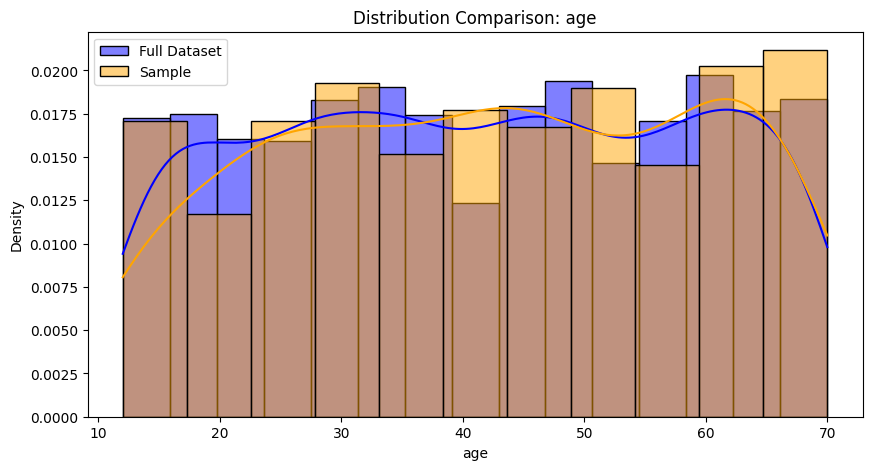

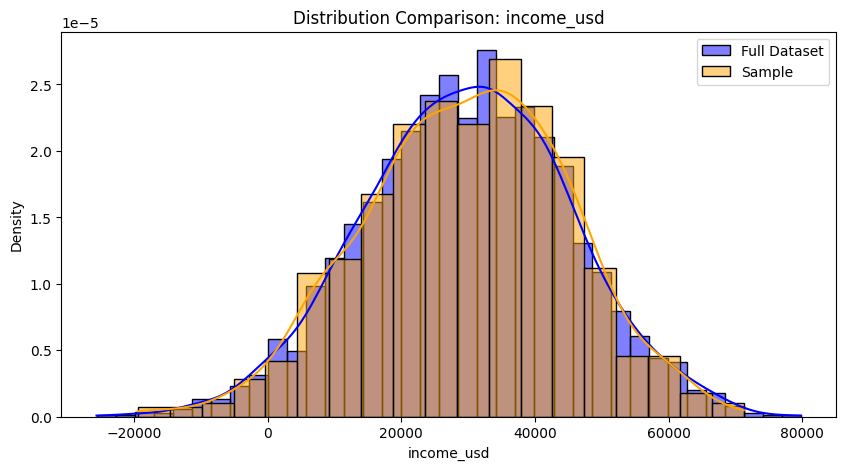

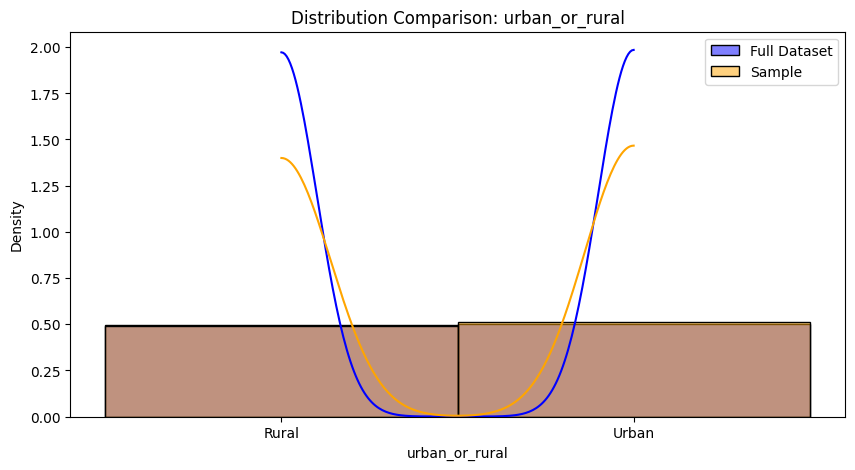

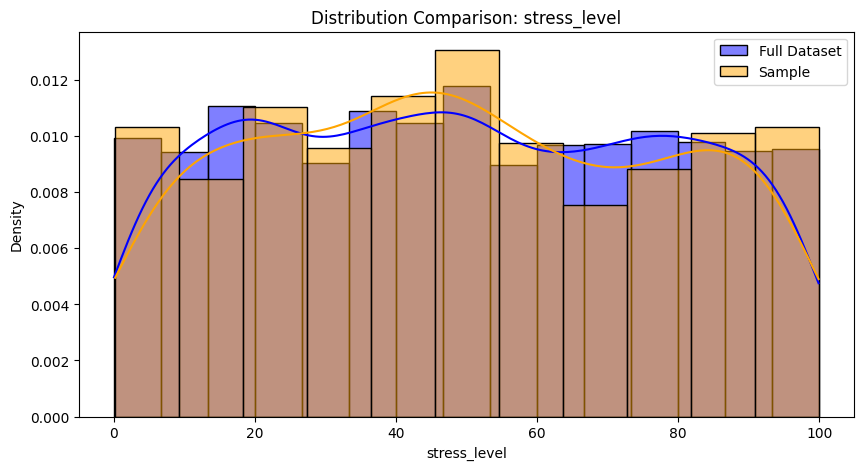

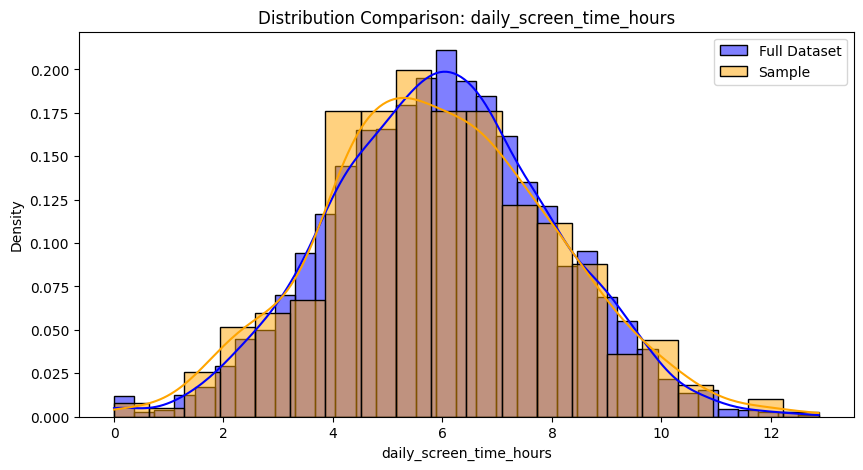

In [21]:
# Mostra e të dhënave

sample_data = df.sample(frac=0.2, random_state=42)

numeric_cols = ['age', 'income_usd', 'urban_or_rural', 'stress_level', 'daily_screen_time_hours']

for col in numeric_cols:
    plt.figure(figsize=(10,5))
    sns.histplot(df[col], color='blue', label='Full Dataset', kde=True, stat="density", alpha=0.5)
    sns.histplot(sample_data[col], color='orange', label='Sample', kde=True, stat="density", alpha=0.5)
    plt.title(f'Distribution Comparison: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [29]:
# Trajtimi i outliers me IQR

Q1 = df["income_usd"].quantile(0.25)
Q2 = df["income_usd"].quantile(0.50)
Q3 = df["income_usd"].quantile(0.75)
Q4 = df["income_usd"].max()

IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (Median): {Q2}")
print(f"Q3 (75th percentile): {Q3}")
print(f"Q4 (Max): {Q4}")
print(f"IQR (Q3 - Q1): {IQR}")

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound: ", lower_bound)
print("Upper Bound: ", upper_bound)

outliers = df[(df["income_usd"] < lower_bound) | (df["income_usd"] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

sum_above_upper = df.loc[df["income_usd"] > upper_bound, "income_usd"].sum()

count_above_upper = (df["income_usd"] > upper_bound).sum()
count_under_upper = (df["income_usd"] < lower_bound).sum()

print(f"Count of values above upper bound: {count_above_upper}")
print(f"Count of values above upper bound: {count_under_upper}")

# Remove outliers from the 'income_usd' column
df_no_outliers = df[(df["income_usd"] >= lower_bound) & (df["income_usd"] <= upper_bound)]

print(f"Original dataset size: {len(df)}")
print(f"Dataset size after removing outliers: {len(df_no_outliers)}")

df_no_outliers.describe()

Q1 (25th percentile): 19482.704999999998
Q2 (Median): 30002.71
Q3 (75th percentile): 40352.0175
Q4 (Max): 79829.55
IQR (Q3 - Q1): 20869.312500000004
Lower Bound:  -11821.26375000001
Upper Bound:  71655.98625000002
Number of outliers: 14
Count of values above upper bound: 4
Count of values above upper bound: 10
Original dataset size: 3000
Dataset size after removing outliers: 2986


,age,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,gaming_usage_hours,streaming_usage_hours,messaging_usage_hours,work_related_usage_hours,sleep_hours,...,online_shopping_hours,monthly_data_usage_gb,age_first_phone,push_notifications_per_day,tech_savviness_score,education_level_encoded,relationship_status_encoded,urban_or_rural_encoded,self_reported_addiction_level_encoded,gender_encoded
count,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,...,2986.000000,2986.000000,2986.000000,2986.000000,2986.000000,2418.000000,2986.000000,2986.000000,2986.000000,2986.000000
mean,41.318486,29876.619066,5.984012,79.696919,1.997405,1.519357,1.989786,1.489585,2.003138,6.493768,...,0.803922,24.892689,13.947421,99.102813,49.497361,1.717122,2.509377,1.498326,2.504689,1.979906
std,17.057653,15075.840248,2.018028,25.134910,0.963884,0.935469,0.981379,0.508757,0.953636,0.994143,...,0.479001,9.725931,3.739362,30.272616,28.842046,1.912279,1.117882,0.500081,1.120307,0.824010
min,12.000000,-11666.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.810000,...,0.000000,0.000000,8.000000,0.000000,0.010000,-1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,19594.062500,4.590000,63.000000,1.340000,0.812500,1.290000,1.140000,1.340000,5.840000,...,0.460000,18.315000,11.000000,79.000000,23.732500,-1.000000,1.250000,1.000000,1.000000,1.000000
50%,42.000000,30035.340000,5.980000,80.000000,2.010000,1.520000,2.005000,1.500000,1.980000,6.490000,...,0.790000,25.045000,14.000000,99.000000,49.205000,1.000000,3.000000,1.000000,3.000000,2.000000
75%,56.000000,40351.297500,7.307500,96.000000,2.640000,2.180000,2.650000,1.840000,2.660000,7.160000,...,1.130000,31.467500,17.000000,119.000000,74.152500,3.000000,3.000000,2.000000,4.000000,3.000000
max,70.000000,71271.660000,12.870000,182.000000,5.050000,4.860000,5.180000,3.070000,5.260000,10.320000,...,2.600000,54.850000,20.000000,204.000000,99.940000,4.000000,4.000000,2.000000,4.000000,3.000000


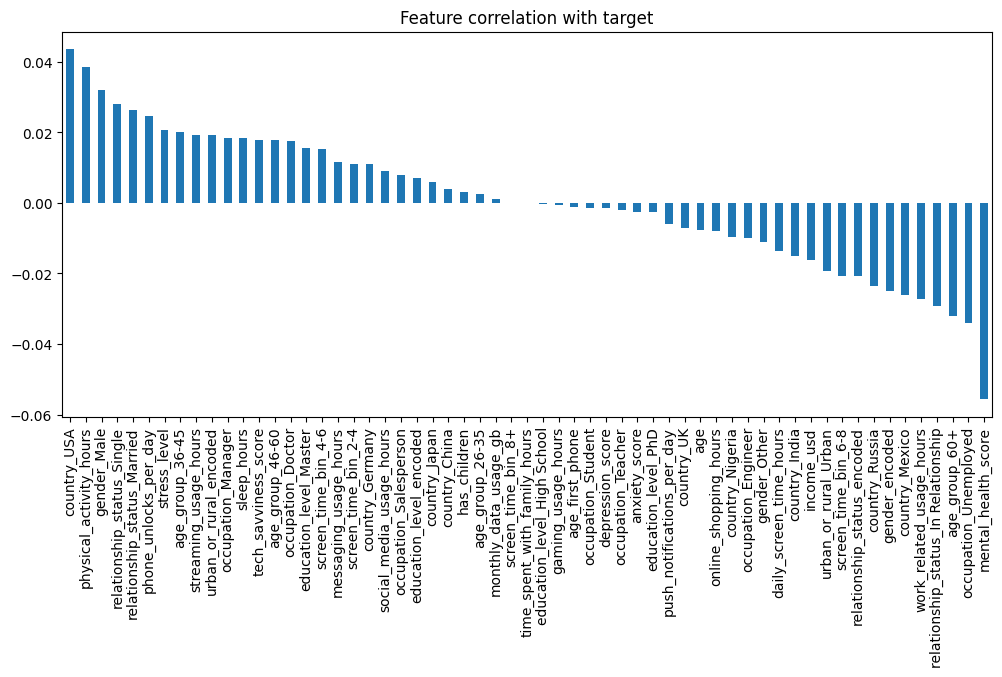

KeyboardInterrupt: 

In [30]:
#zgjedhja e nën bashkësisë së vetive
target_column = "self_reported_addiction_level"
X = df.drop(columns=[target_column, "self_reported_addiction_level_encoded"], errors='ignore')

y = df[target_column]

le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_encoded = pd.get_dummies(X, drop_first=True)


X_encoded = X_encoded.apply(pd.to_numeric, errors='coerce')
X_encoded = X_encoded.fillna(0)

# 4️ Correlation with target
corr = X_encoded.corrwith(pd.Series(y_encoded))
plt.figure(figsize=(12,5))
corr.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature correlation with target")
plt.show()

# 5️ Feature selection using SelectKBest (f_classif)
selector = SelectKBest(score_func=f_classif, k=5)  # select top 5 features
X_new = selector.fit_transform(X_encoded, y_encoded)
top_features_f = X_encoded.columns[selector.get_support()]
#print("Top 5 features (SelectKBest f_classif):", top_features_f.tolist())

# 6️ Recursive Feature Elimination (RFE) with RandomForest
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_encoded, y_encoded)
top_features_rfe = X_encoded.columns[rfe.support_]
print("Top 5 features (RFE with RandomForest):", top_features_rfe.tolist())

In [ ]:
# Diskretizimi i 'daily_screen_time_hours' ne kategori
bins = [0, 2, 5, 8, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
df['Screen_Time_Category'] = pd.cut(df['daily_screen_time_hours'], bins=bins, labels=labels)
print("\n✅ Diskretizimi u aplikua mbi kolonën 'Daily_Screen_Time_Hours'")
print(df[['daily_screen_time_hours', 'Screen_Time_Category']].head())





✅ Diskretizimi u aplikua mbi kolonën 'Daily_Screen_Time_Hours'
   daily_screen_time_hours Screen_Time_Category
0                     5.81                 High
1                     9.05            Very High
2                     5.76                 High
3                     6.71                 High
4                     6.31                 High


In [14]:
#Binarizimi
binarize_cols = [
    'gender', 'relationship_status', 'urban_or_rural', 'has_children'
]

binarized_dfs = []

for col in binarize_cols:
    if col in df.columns:
        
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)

        dummies = pd.get_dummies(df[col], prefix=col, dtype=int)  
        df = pd.concat([df, dummies], axis=1)
        binarized_dfs.append(dummies)
        print(f" U krye binarizimi për kolonën: {col}")
    else:
        print(f"Kolona '{col}' nuk ekziston — u anashkalua.")

if binarized_dfs:
    binarized_result = pd.concat(binarized_dfs, axis=1)
    print("\n--- Kolonat e binarizuara (me 0 dhe 1) ---")
    print(binarized_result.head(5))
else:
    print("\n Asnjë kolonë nuk u binarizua — kontrollo emrat e kolonave.")

df.head()


 U krye binarizimi për kolonën: gender
 U krye binarizimi për kolonën: relationship_status
 U krye binarizimi për kolonën: urban_or_rural
 U krye binarizimi për kolonën: has_children

--- Kolonat e binarizuara (me 0 dhe 1) ---
   gender_Female  gender_Male  gender_Other  relationship_status_Divorced  \
0              0            1             0                             0   
1              0            1             0                             0   
2              0            0             1                             0   
3              1            0             0                             0   
4              0            0             1                             1   

   relationship_status_In Relationship  relationship_status_Married  \
0                                    0                            0   
1                                    1                            0   
2                                    0                            0   
3                         

,user_id,country,age,gender,occupation,education_level,income_usd,daily_screen_time_hours,phone_unlocks_per_day,social_media_usage_hours,...,gender_Male,gender_Other,relationship_status_Divorced,relationship_status_In Relationship,relationship_status_Married,relationship_status_Single,urban_or_rural_Rural,urban_or_rural_Urban,has_children_No,has_children_Yes
0,1,India,32,Male,Salesperson,High School,43865.49,5.81,75,0.84,...,1,0,0,0,0,1,1,0,1,0
1,2,UK,26,Male,Artist,Master's,41868.19,9.05,61,3.13,...,1,0,0,1,0,0,1,0,1,0
2,3,Germany,70,Other,Doctor,High School,59636.51,5.76,58,2.12,...,0,1,0,0,0,1,0,1,0,1
3,4,UK,44,Female,Engineer,NaN,39022.07,6.71,80,1.60,...,0,0,0,1,0,0,0,1,1,0
4,5,Brazil,46,Other,Student,NaN,-783.98,6.31,136,1.51,...,0,1,1,0,0,0,0,1,1,0


In [15]:
#Krijimi i vetive të reja
# Sa orë kalon përdoruesi në aktivitete argëtuese
df['Total_Entertainment_Hours'] = (
    df['social_media_usage_hours'] +
    df['gaming_usage_hours'] +
    df['streaming_usage_hours'] +
    df['messaging_usage_hours']
)

# Indeksi i shëndetit mendor
df['Overall_Mental_Health_Index'] = (
    df['mental_health_score'] -
    (df['stress_level'] + df['depression_score'] + df['anxiety_score']) / 3
)

print(" U krijuan vetitë e reja!")
print(df[['Total_Entertainment_Hours', 'Overall_Mental_Health_Index']].head())


 U krijuan vetitë e reja!
   Total_Entertainment_Hours  Overall_Mental_Health_Index
0                       4.09                    -5.303333
1                       8.85                    41.530000
2                       7.90                    -5.870000
3                       8.63                    25.950000
4                       6.02                    43.826667
